# Step for validation on all data 

# Import

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from modules import function, utils, cleaning, qrsdetection, mecgcanceller, metrics, fecgextraction


# Function

In [3]:
def load_record(path):
    df = pd.read_csv(path, skiprows=1)
    df.columns = [c.replace("'", "").strip() for c in df.columns]
    df = df.apply(pd.to_numeric, errors='coerce')
    t = df["seconds"].values
    fs = 1 / np.mean(np.diff(t))
    X = df[["uV", "uV.1", "uV.2", "uV.3"]].values
    return X, fs

def load_true_fqrs(path):
    txt = path.replace(".dat", ".fqrs.txt").replace(".csv", ".fqrs.txt")
    if os.path.exists(txt):
        return np.loadtxt(txt, dtype=int)
    return None

In [4]:
def process_record(X, fs,true_fqrs, pos, record):
    S2 = cleaning.baseline_wander_removal(X, fs)

    S3 = cleaning.powerline_interference_canceller(
        S2, fs, mu_w=1e-4, mu_f=1e-7, harmonics=[1,2,3]
    )

    S4, fs_up = cleaning.upsample_to_2kHz(S3, fs)


    mQRS_clean, PC1_maternal_clean, corr_maternal_clean, maternal_template_clean = qrsdetection.detect_mQRS(S4, fs_up)

    S4_pre = S4.copy()

    if record in ["a02.csv","a06.csv","a07.csv","a09.csv","a10.csv","a11.csv","a15.csv","a16.csv", "a18.csv","a21.dat", "a02.dat","a06.dat","a07.dat","a09.dat","a10.dat","a11.dat","a15.dat","a16.dat", "a18.dat","a21.dat"]:
        N_mecg = 10
    else:
        N_mecg = 30
 
    for i in range(3):
        S4 = mecgcanceller.mecg_canceller(S4, mQRS_clean, fs_up, N=N_mecg)

    S5 = S4
    PC1_fetal = qrsdetection.pca_first_component(S5)
    clean_fQRS, PC1_f, corr_f, tmpl_f = qrsdetection.detect_fQRS(S5, fs_up )



    FHR_f = function.compute_FHR(clean_fQRS, fs_up)

    FHR_m = function.compute_FHR(mQRS_clean, fs_up)

    S6, Nav_used = function.calculate_average_fecg_from_pc(PC1_fetal, clean_fQRS, fs_up)


    win_ms = 100
    win = int((win_ms/1000) * fs_up)

    S6 = np.zeros((2*win, S5.shape[1]))

    for ch in range(S5.shape[1]):
        segments = []
        for q in clean_fQRS[:150]:  
            if q-win >= 0 and q+win < len(S5):
                seg = S5[q-win:q+win, ch]
                segments.append(seg)
        S6[:, ch] = np.mean(segments, axis=0)

    plt.figure(figsize=(9,4))
    for i in range(S6.shape[1]):
        plt.plot(S6[:, i], color=plt.cm.plasma(i / S6.shape[1]))
    plt.title(f"Average fetal ECG complex: a{pos}" )
    plt.show()

    S6_pc, Nav_used = function.calculate_average_fecg_from_pc(PC1_fetal, clean_fQRS, fs_up)

    peak_index = np.argmax(np.abs(S6_pc))

    if S6_pc[peak_index] < 0:
        S6_pc = -S6_pc

    plt.figure(figsize=(10,4))
    plt.plot(S6_pc, color='purple', linewidth=2)
    plt.title(f"Average Fetal ECG Complex: a{pos} (Nav={Nav_used})") 
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

    reliability, mean_bpm, is_successfull = metrics.calculate_paper_metrics(clean_fQRS, fs_up, S5.shape[0])

    sir_gain = utils.calculate_sir_gain(S4_pre, S5, mQRS_clean, fs_up)
    fSNR = utils.calculate_fetal_snr(S5, clean_fQRS, fs_up)
    
    SNR_dB, SIR_dB = metrics.compute_snr_sir_martens(S4_pre, S5, S6, clean_fQRS, fs_up)

    metrics_val = metrics.compute_metrics(clean_fQRS,true_fqrs,fs_up)

    return  fs_up, S4_pre, S5, S6, mQRS_clean, clean_fQRS, reliability, mean_bpm, is_successfull, sir_gain, fSNR,SNR_dB, SIR_dB, FHR_f, FHR_m, metrics_val



Processing: ./dataset/set-a-text\a01.csv


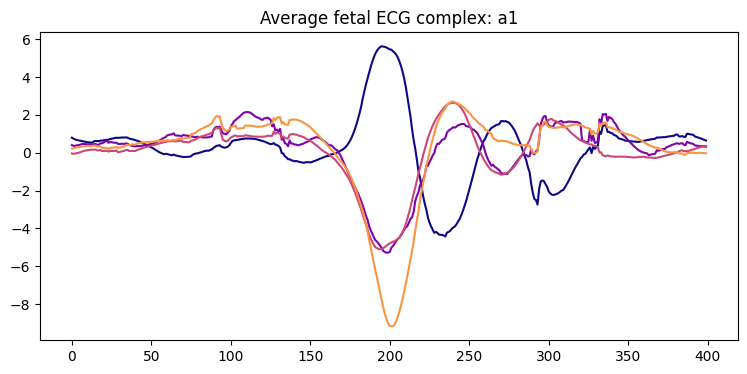

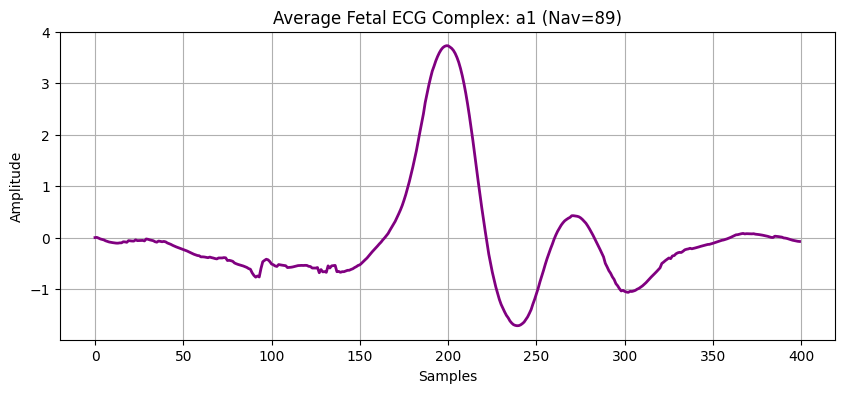

Processing: ./dataset/set-a-text\a02.csv


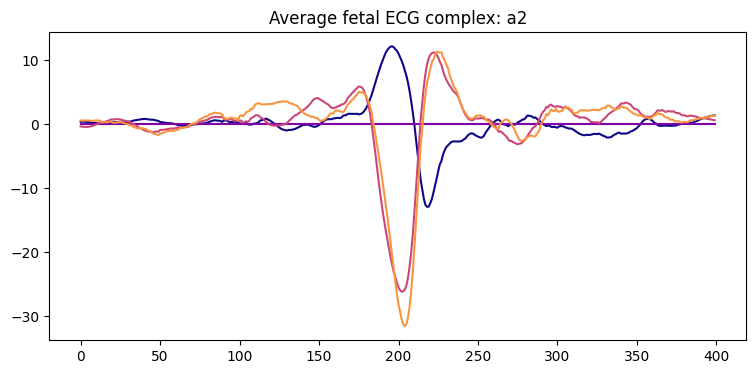

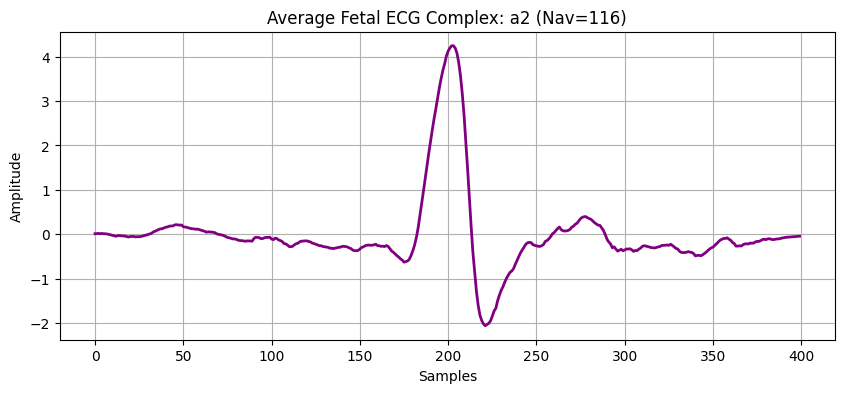

c:\Users\Angelica\Desktop\GitHub\Other_Biomedical_Project\modules\metrics.py:41: RuntimeWarning: invalid value encountered in divide
  SNR = PF / PN
c:\Users\Angelica\Desktop\GitHub\Other_Biomedical_Project\modules\metrics.py:42: RuntimeWarning: invalid value encountered in divide
  SIR = PF / PM


Processing: ./dataset/set-a-text\a03.csv


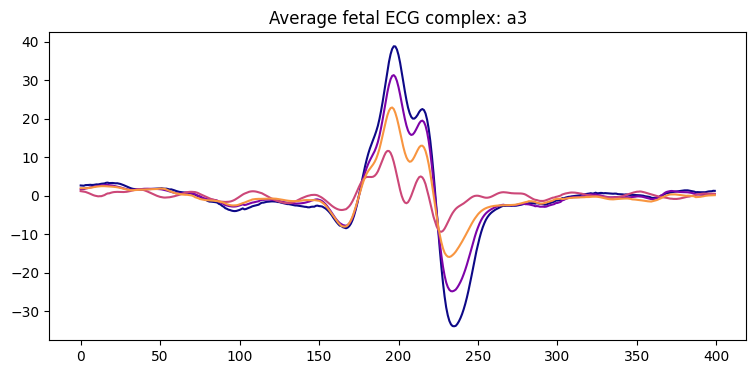

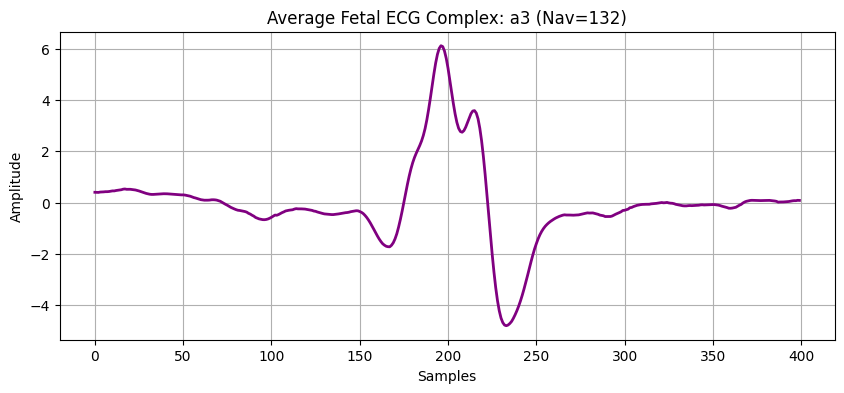

Processing: ./dataset/set-a-text\a04.csv


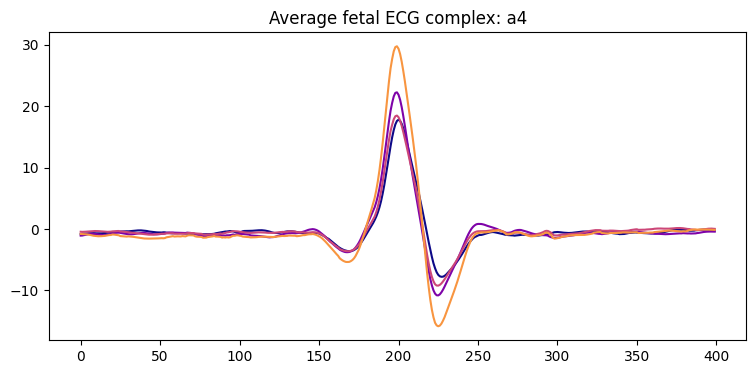

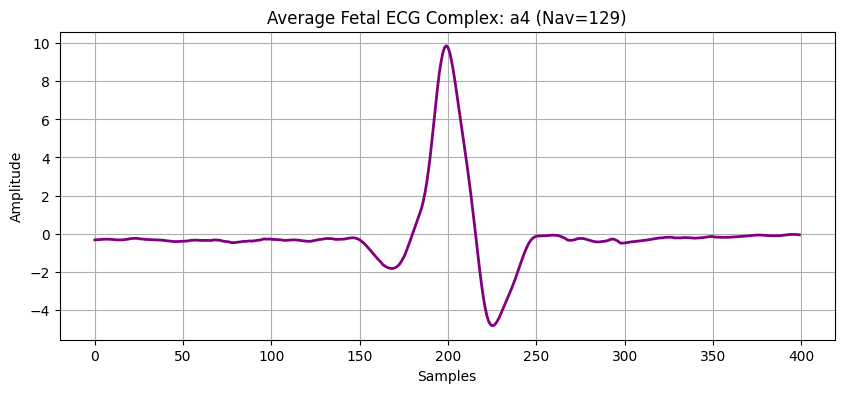

Processing: ./dataset/set-a-text\a05.csv


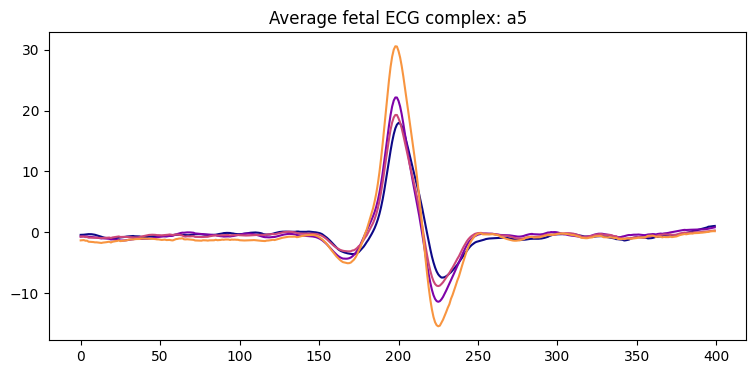

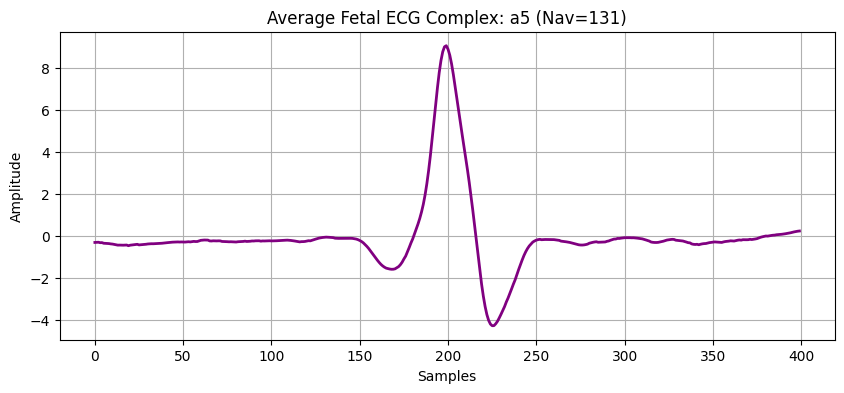

Processing: ./dataset/set-a-text\a06.csv


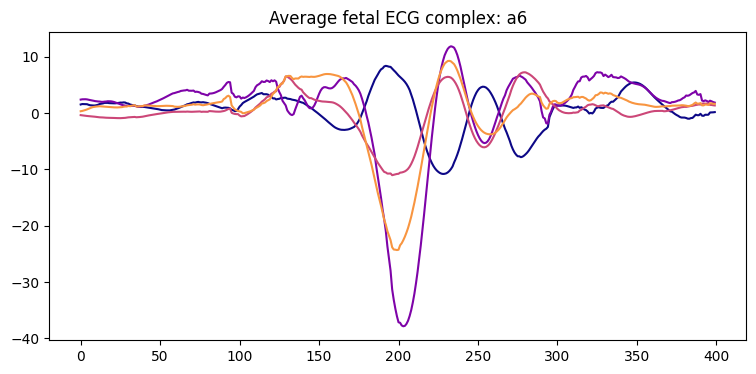

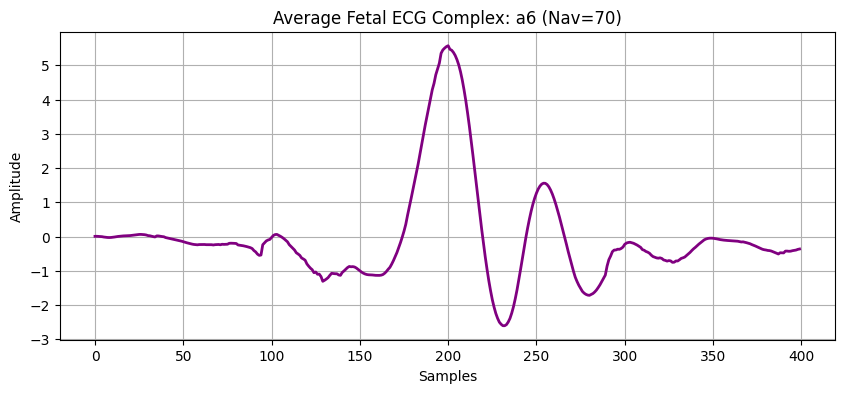

Processing: ./dataset/set-a-text\a07.csv


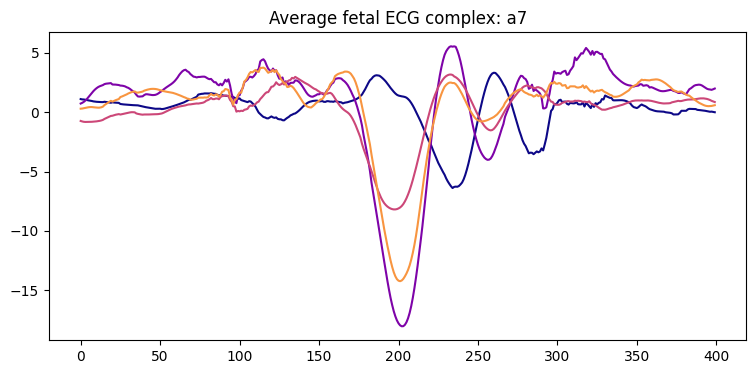

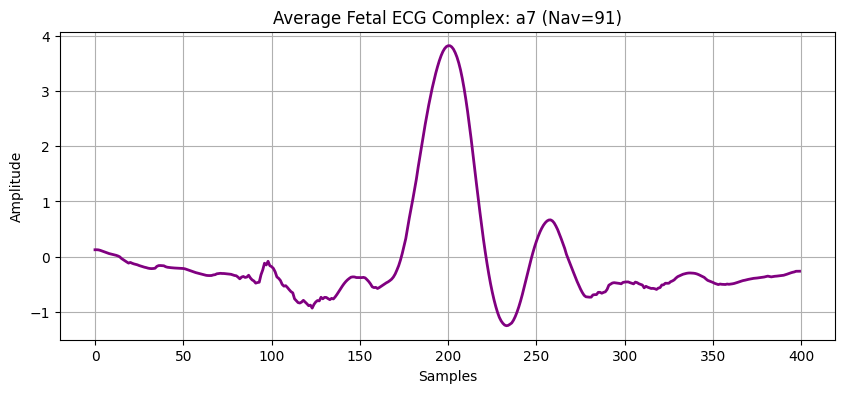

Processing: ./dataset/set-a-text\a08.csv


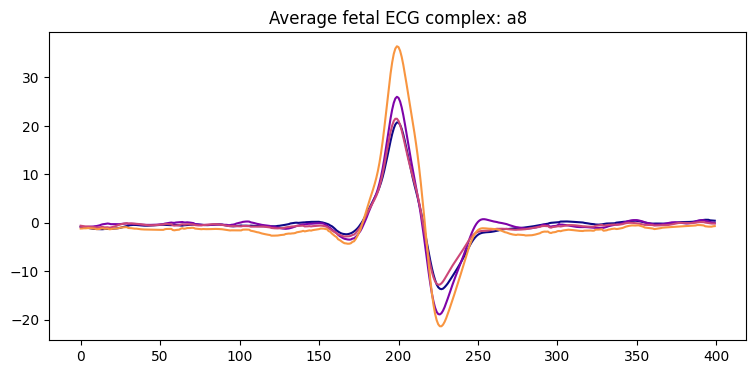

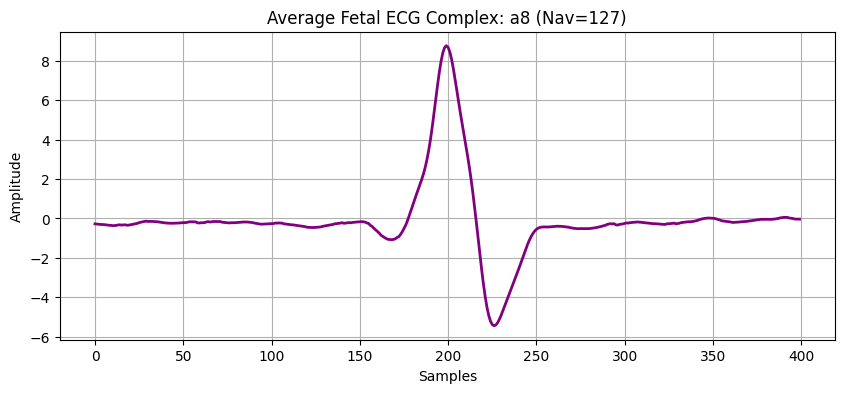

Processing: ./dataset/set-a-text\a09.csv


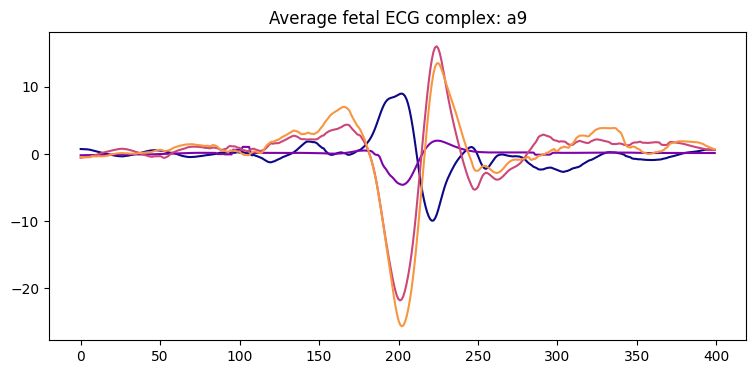

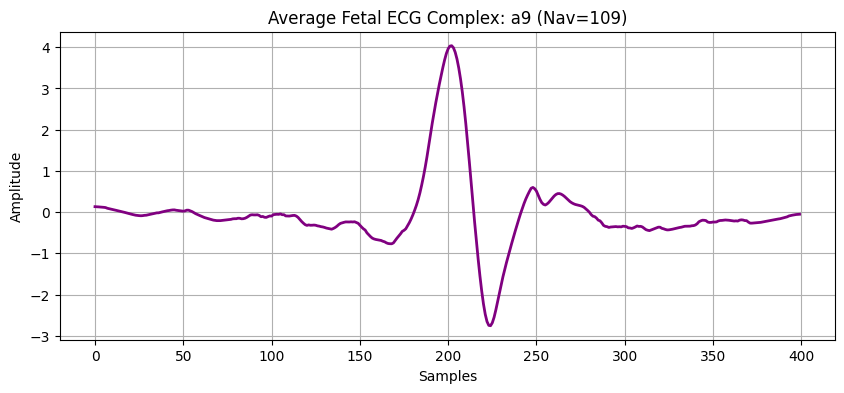

Processing: ./dataset/set-a-text\a10.csv


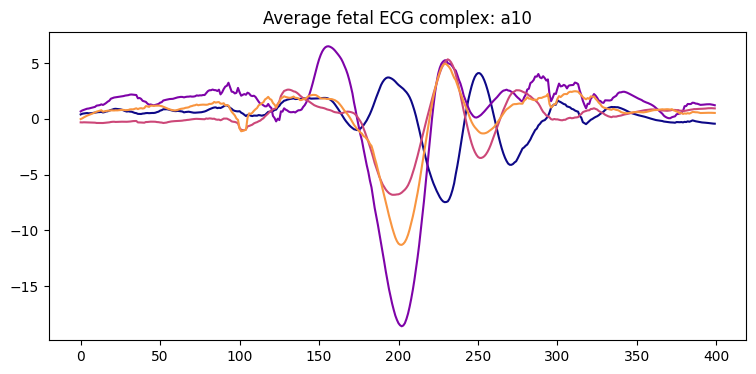

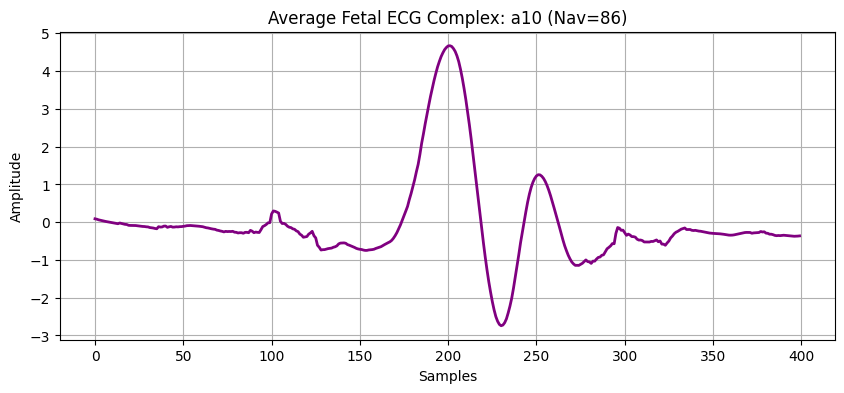

Processing: ./dataset/set-a-text\a11.csv


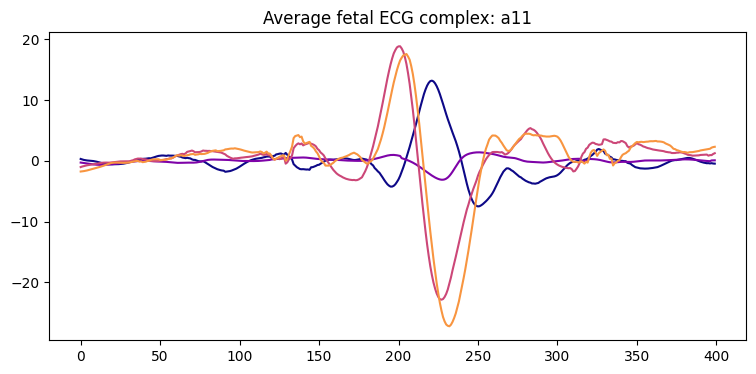

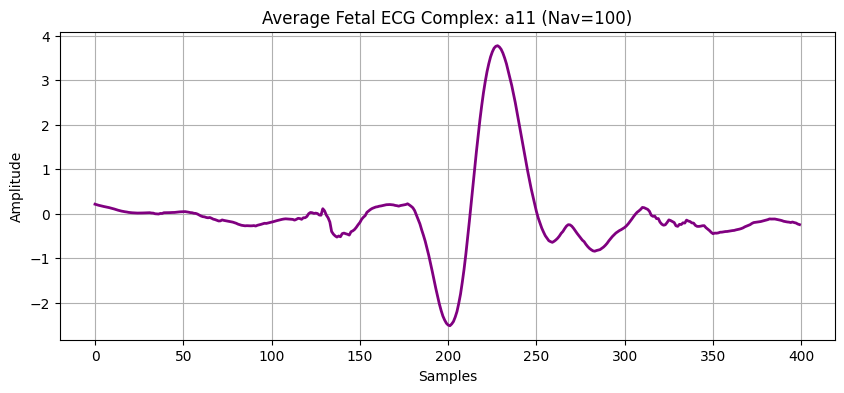

Processing: ./dataset/set-a-text\a12.csv


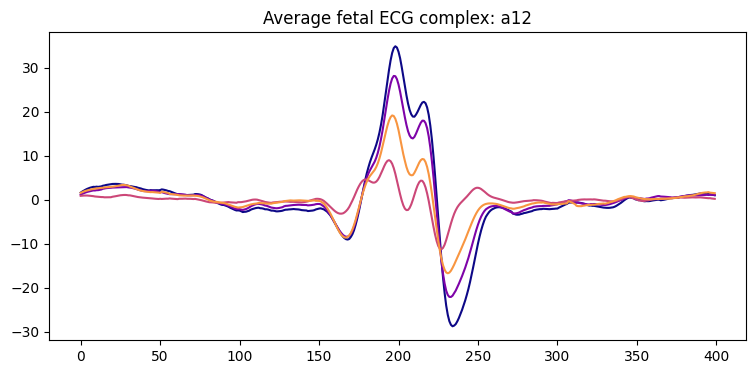

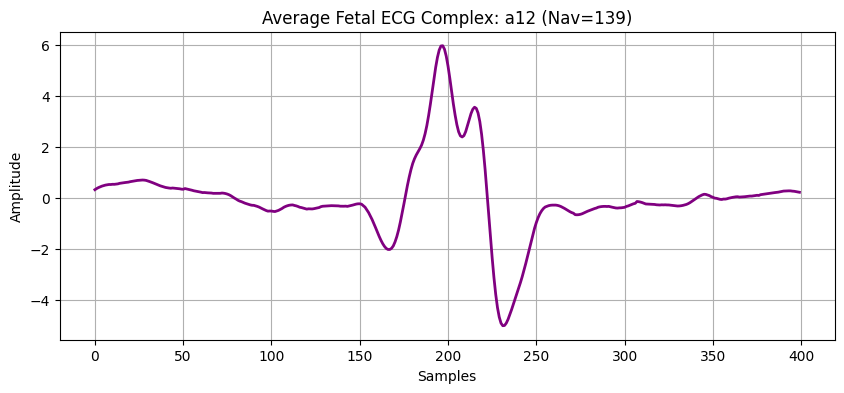

Processing: ./dataset/set-a-text\a13.csv


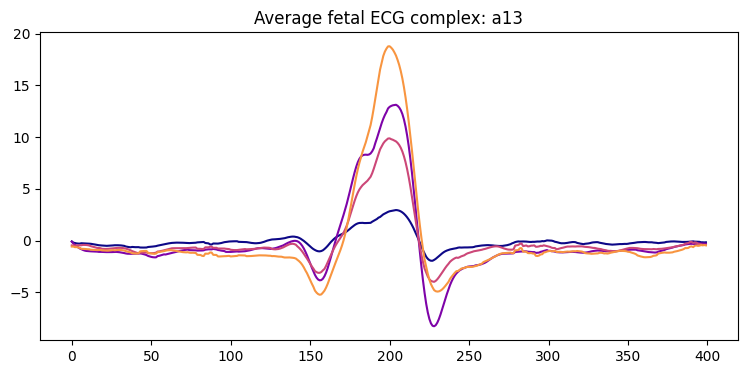

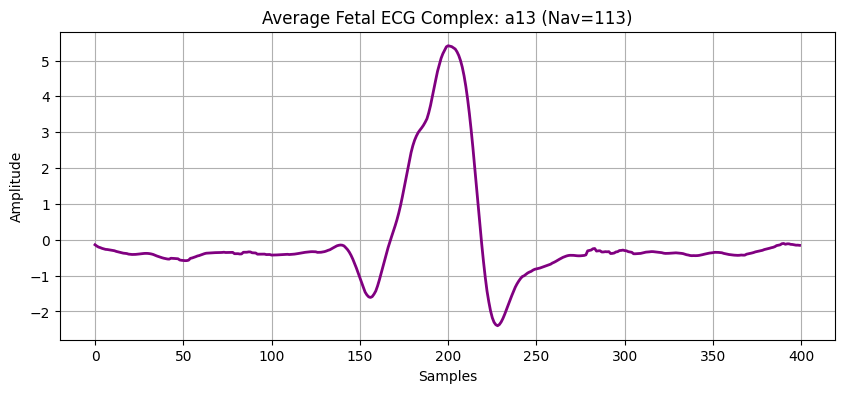

Processing: ./dataset/set-a-text\a14.csv


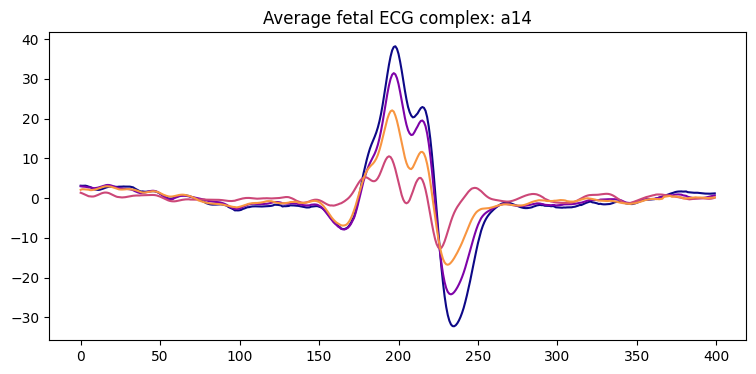

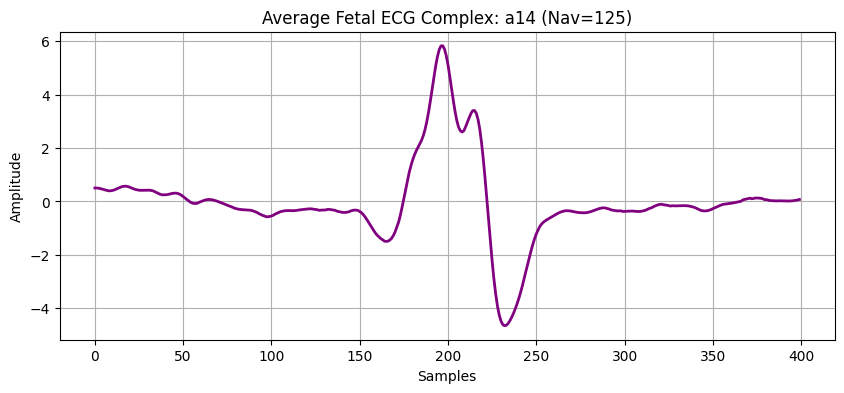

Processing: ./dataset/set-a-text\a15.csv


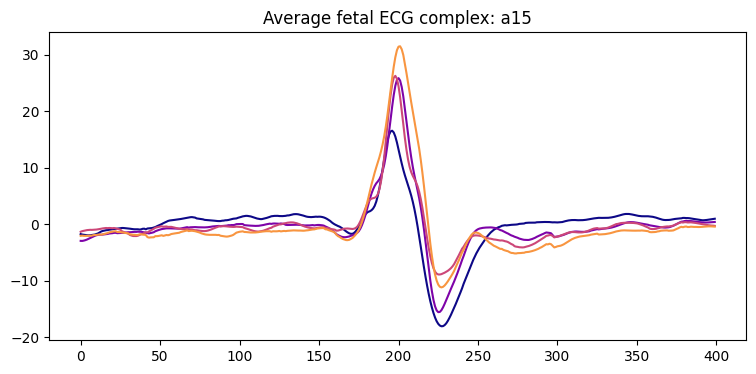

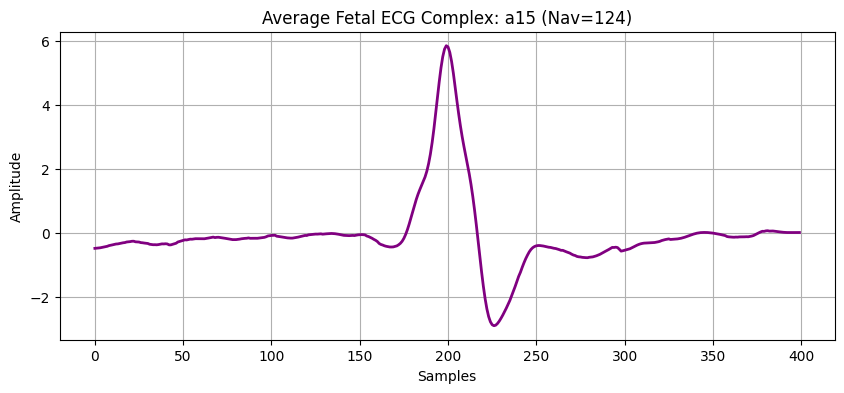

Processing: ./dataset/set-a-text\a16.csv


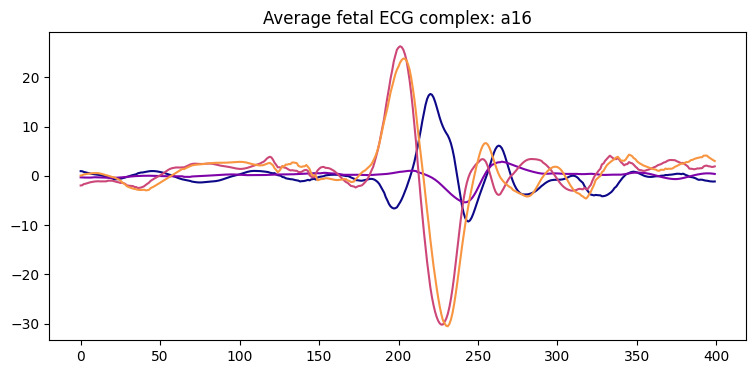

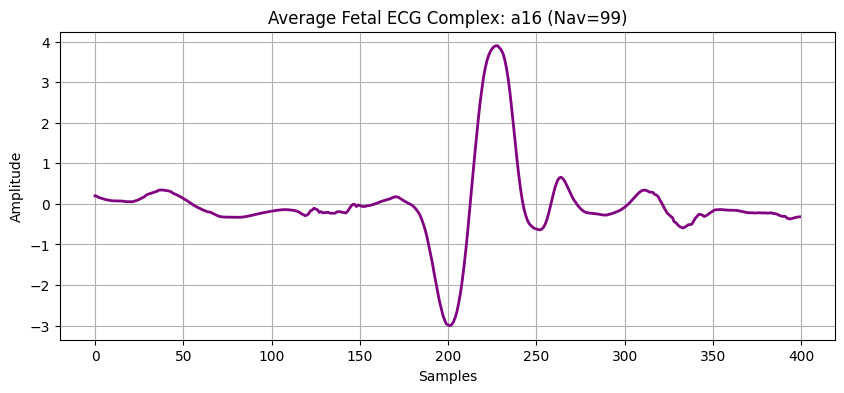

Processing: ./dataset/set-a-text\a17.csv


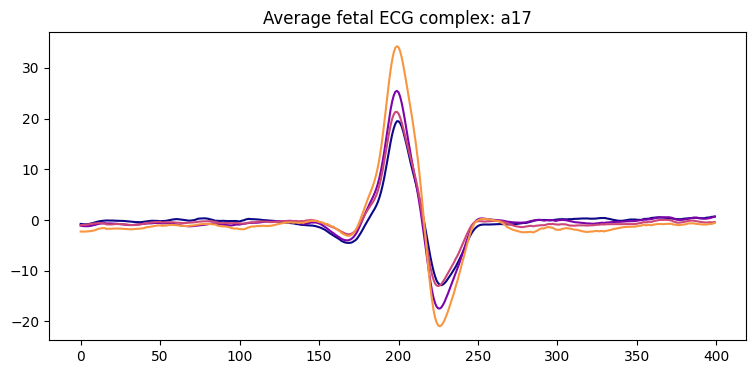

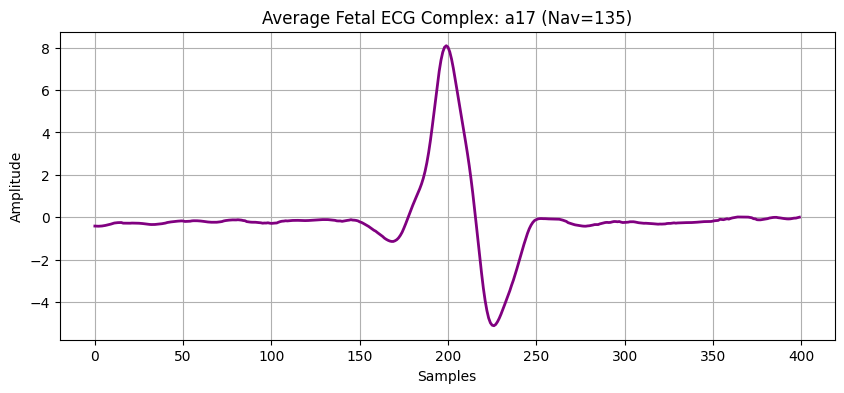

Processing: ./dataset/set-a-text\a18.csv


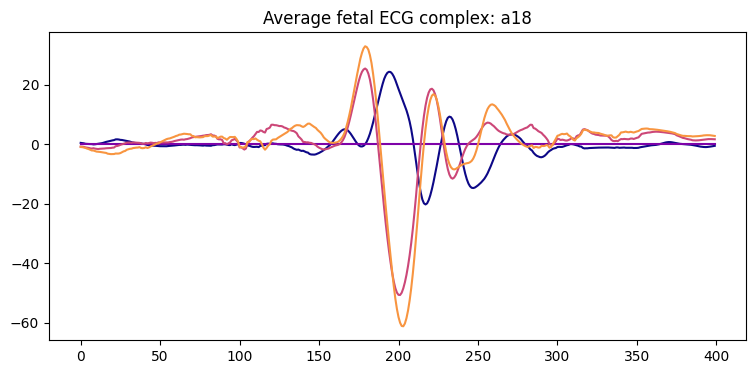

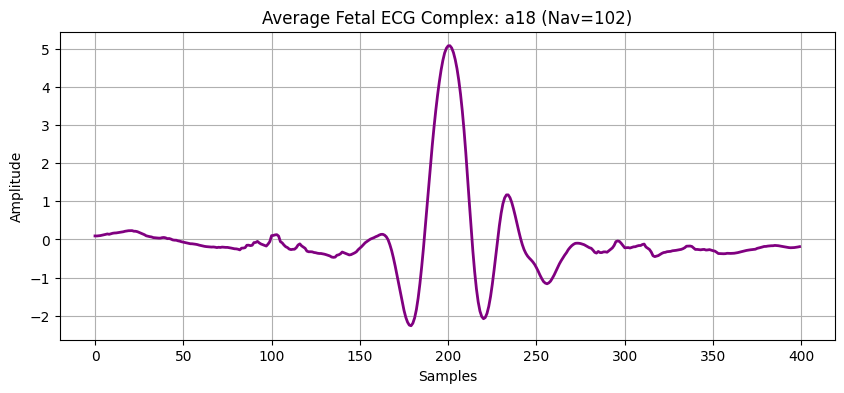

c:\Users\Angelica\Desktop\GitHub\Other_Biomedical_Project\modules\metrics.py:41: RuntimeWarning: invalid value encountered in divide
  SNR = PF / PN
c:\Users\Angelica\Desktop\GitHub\Other_Biomedical_Project\modules\metrics.py:42: RuntimeWarning: invalid value encountered in divide
  SIR = PF / PM


Processing: ./dataset/set-a-text\a19.csv


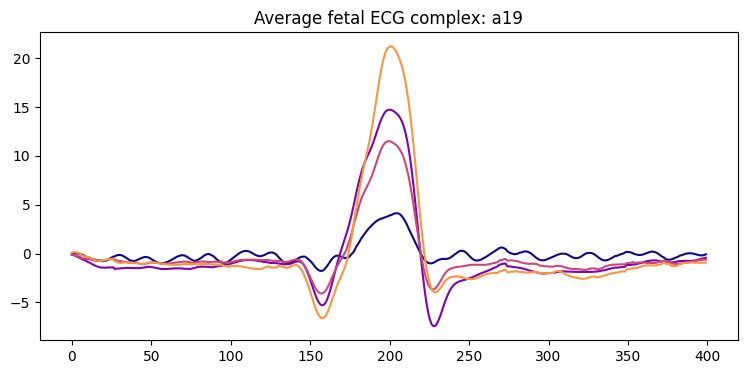

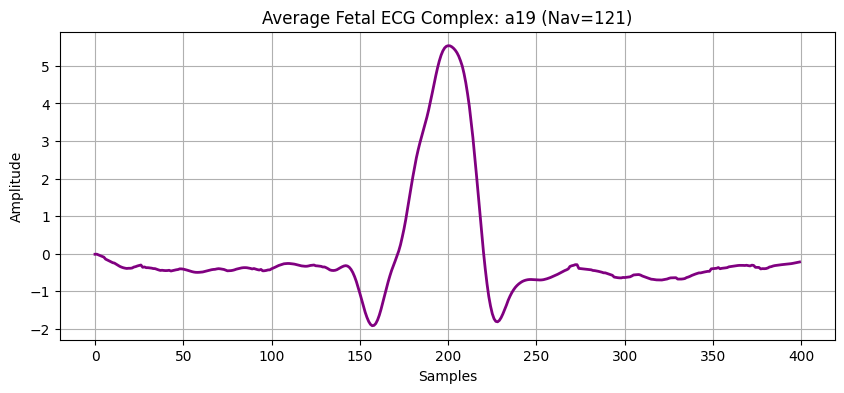

Processing: ./dataset/set-a-text\a20.csv


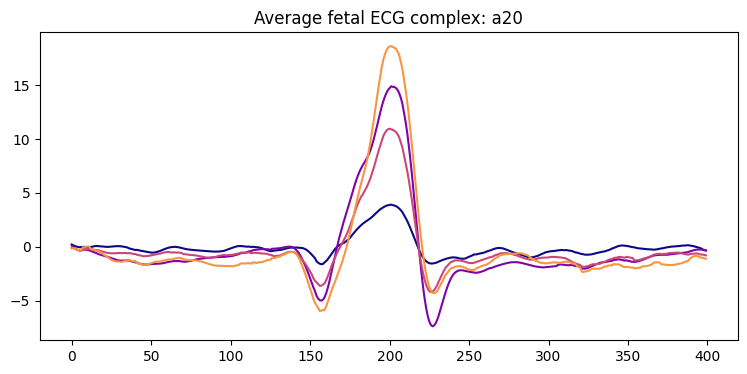

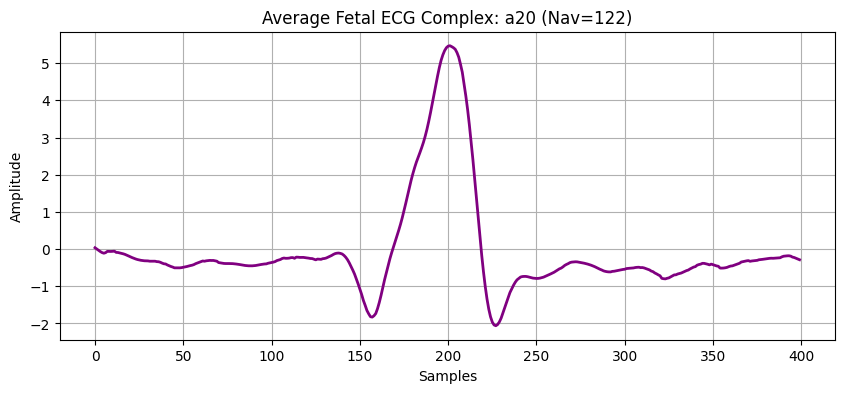

Processing: ./dataset/set-a-text\a21.csv


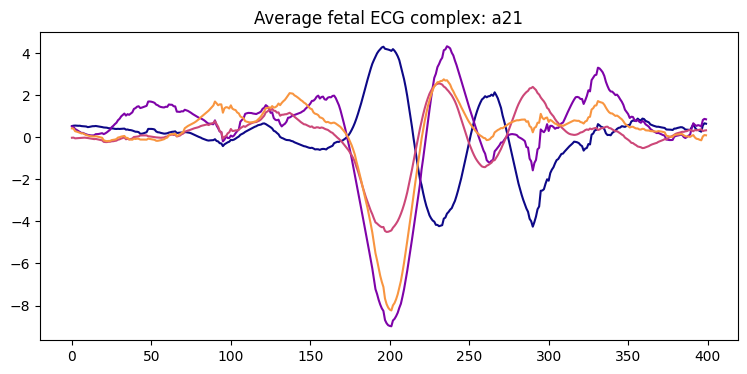

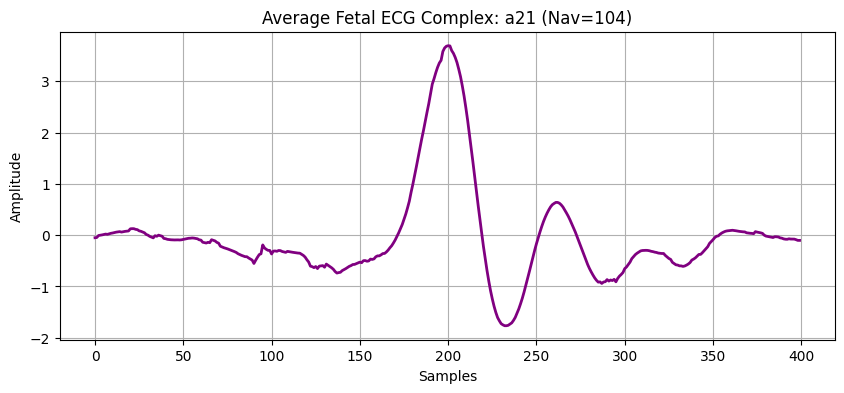

Processing: ./dataset/set-a-text\a22.csv


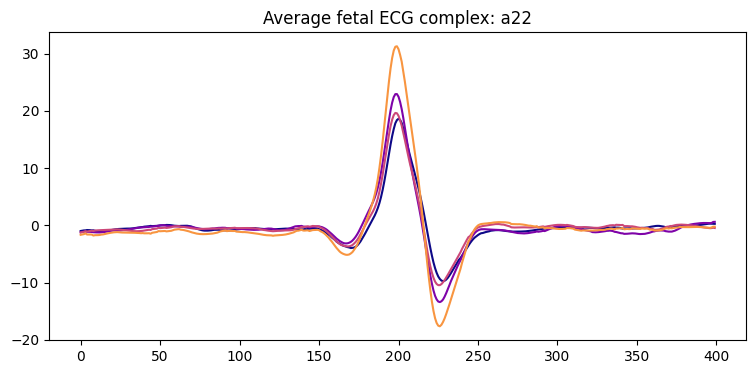

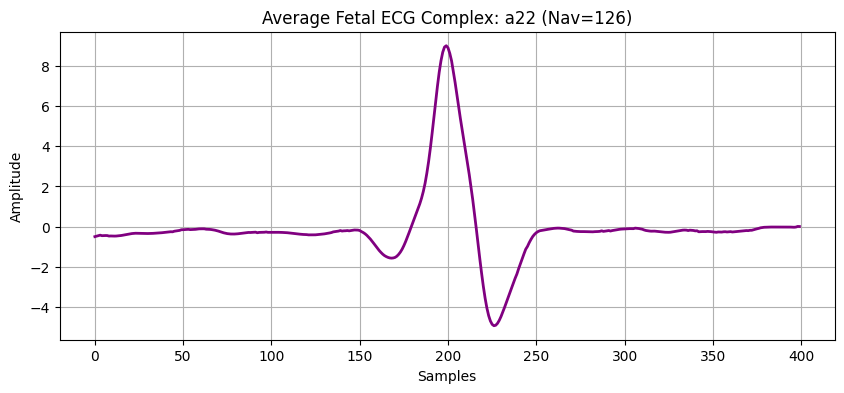

Processing: ./dataset/set-a-text\a23.csv


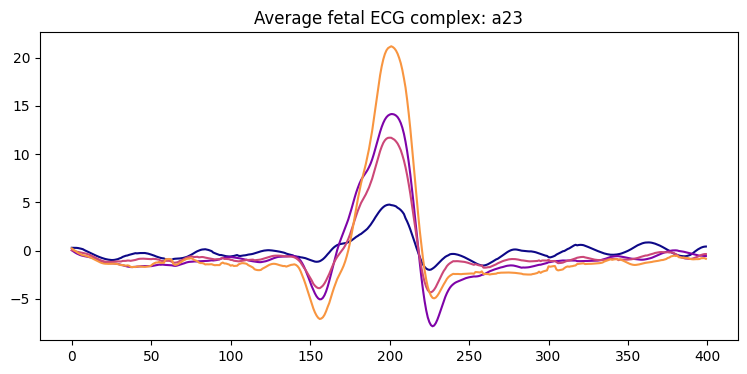

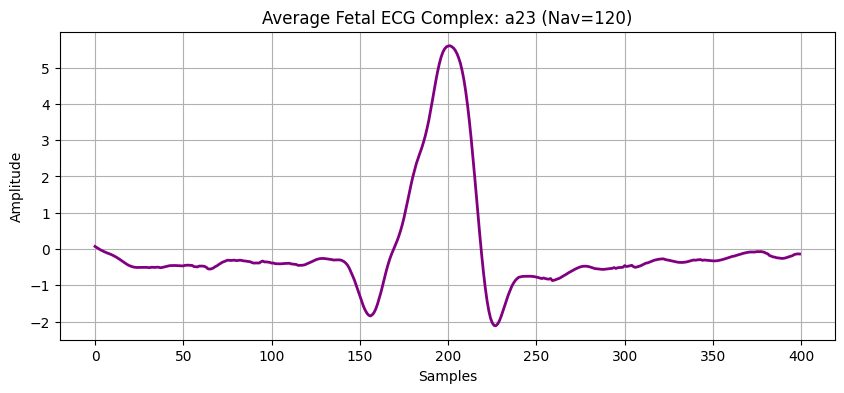

Processing: ./dataset/set-a-text\a24.csv


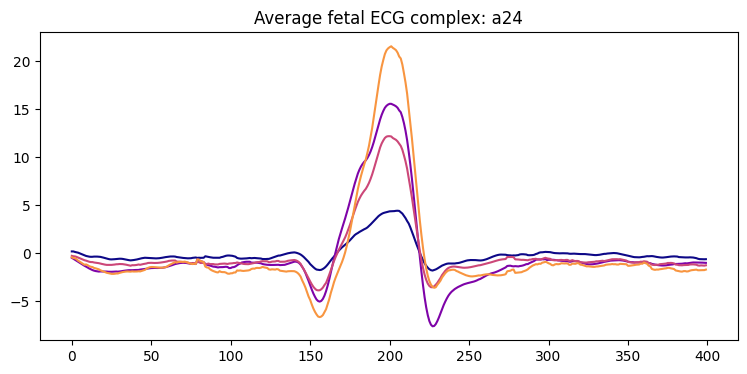

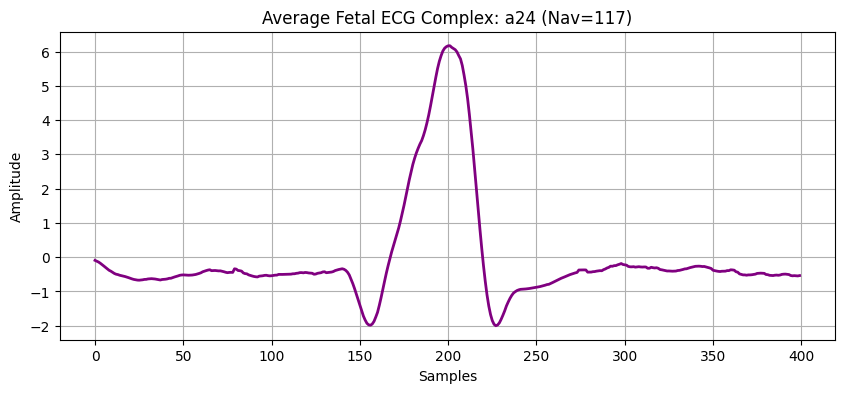

Processing: ./dataset/set-a-text\a25.csv


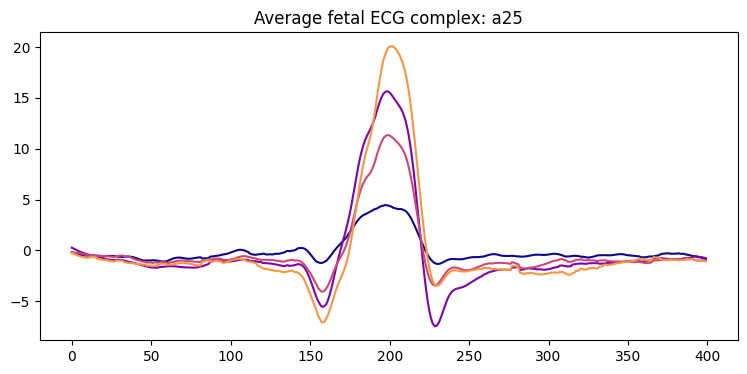

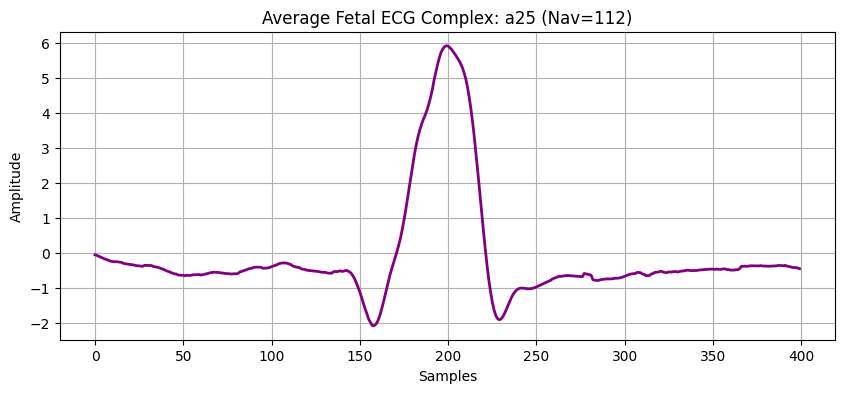

     record  reliability  mean_bpm_f  mean_real_bpm_f  isSuccess  sir_gain_dB  \
0   a01.csv     0.363636  125.081792       152.091499      False    11.728551   
1   a02.csv     0.301724  150.900063       160.427807      False     8.524070   
2   a03.csv     0.816794  140.903551       130.151844       True     9.497521   
3   a04.csv     0.945312  130.210438       128.755365       True     8.703727   
4   a05.csv     0.946565  135.506029       128.617511       True     7.743697   
5   a06.csv     0.449275   85.582742       161.290323      False     8.896088   
6   a07.csv     0.362637  124.911642       130.434783      False     8.261384   
7   a08.csv     0.952756  127.996579       127.659574       True     6.633228   
8   a09.csv     0.532110  129.108917       130.151844      False     7.859898   
9   a10.csv     0.447059  103.837789       183.486239      False     8.989857   
10  a11.csv     0.530000  116.373225       140.186916      False     8.690502   
11  a12.csv     0.876812  14

In [ ]:
import glob


results=[]
pos = 1

for path in sorted(glob.glob("./dataset/set-a-text/*")):
        if not (path.endswith(".csv") or path.endswith(".dat")):
            continue

        print("Processing:", path)

        X, fs = load_record(path)
        true_fqrs = load_true_fqrs(path)
        true_qrs_samples_up = (true_fqrs * 2).astype(int)
        mean_real_bpm = function.c_mean_bpm(true_qrs_samples_up,2000)

        record_name = os.path.basename(path)
        fs_up, S4_pre, S5, S6, mQRS_clean, clean_fQRS, reliability, mean_bpm, is_successfull, sir_gain, fSNR,SIR,SNR, FHR_f, FHR_m, match_metrics = process_record(X, fs, true_qrs_samples_up, pos, record_name)

        pos=pos+1
        metrics_v = {}
        metrics_v["record"] = os.path.basename(path)
        metrics_v["reliability"] = reliability
        metrics_v["mean_bpm_f"] = mean_bpm
        metrics_v["mean_real_bpm_f"] = mean_real_bpm
        metrics_v["isSuccess"] = is_successfull
        metrics_v["sir_gain_dB"] = sir_gain
        metrics_v["fSNR_dB"] = fSNR
        metrics_v["SIR"] = SIR
        metrics_v["SNR"] = SNR


        metrics_v.update(match_metrics)
        results.append(metrics_v)
        
df_results = pd.DataFrame(results)
print(df_results)
df_results.to_csv("result\A_RESULT.csv", index=False)
print("\nSaved")
